# **Modern Convnet Architecture**
Una Convent basica è composta da un insieme di layer convulazionali e di Max Pooling, per poi concludere con un layer flatten e successivamente un Dense Layer (se si ha un problema di image classification).

Le Convnet più moderne e complesse, presentano anche altri tipi di layer. In questo notebook verranno approfondite le architetture più esenziali di Convnet, in particolare: residual connections, batch normalization e separable convolutions.

# **Residual Connections**
in un modello sequenziale di Deep Learning, **la backpropagation porta un errore cumulativo che si propaga tra i vari blocchi**. Più si scende, **maggiore questo errore cumulativo sarà elevato**. Questo perchè si ha una catena di funzione dove bisogna adattare i pesi a quest'ultime. **Ogni passaggio in queste funzione introduce una certa quantità di rumore, che rappresenta l'errore.** \\
Se la catena di funzioni è troppo profonda questo errore potrebbe travolgere le informazioni del gradiente e la backpropagation smetterebbe di funzione. **Questo è un problema chiamato vanishing del gradiente**. \\
La soluzione a questo problema è semplice: **bisogna forzare ogni funzione nella catena di conservare una versione senza rumore delle informazioni nell'input precedente.** Il modo più semplice per fare questo è tramite la **Residual Connection: Aggiungo l'input di una funzione/blocco al suo output,** in modo che le informazioni del gradiente sull'errore possano essere propagate senza rumore.

**NB: Questo porta alla necessità che input e output devono avere la stessa shape**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs) #Output Shape(30,30,32)
residual = x #Tengo traccia dei dati di input, in modo da poterli aggiungere all'output -> Shape(30,30,32)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(x) #output shape (30,30,64), perchè il padding=same.
residual = layers.Conv2D(64, 1)(residual) #Portiamo i residui da (30,30,32) a (30,30,64)

x = layers.add([x, residual]) #Adesso che i due dati hanno la stessa shape, possono essere uniti.

Su viene mostrato **come gestire i dati residuali nel momento in cui i dati di input vengono dati in pasto a una serie di layer convulazionali** che **modificano il numero dei canali di output e la shape delle immagini** se il kernel non è centrato perfettamente.

Infatti, **dopo che i dati di input vengono dati in pasto a dei layer convulazioni**, **la shape dei dati di output sarà diversa rispetto ai residui.**
Per portare i residui sulla stessa shape dei dati di output, si danno in input a un **layer convulazione con kernel 1x1** e con un numero di filtri che ci permette di raggiungere quelli di output. **Così facendo, la dimensione non verrà modificata (visto che si utilizza un kernel 1x1), ma i canali si.**

**Di conseguenza i dati avranno la stessa shape e potranno essere uniti tramite il .add()**

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))

x = layers.Conv2D(32, 3, activation="relu")(inputs) #Output shape (30,30,32)
residual = x #Shape residual = (30,30,32)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(x) #Output shape (30,30,64)
x = layers.MaxPooling2D(2, padding="same")(x) #Output shape (15,15,64)

residual = layers.Conv2D(64, 1, strides=2)(residual) #Porto il residual da shape (30,30,32) a (15,15,64)
x = layers.add([x, residual])

In quest'altro caso, viene mostrato c**ome gestire i residui nel momento in cui i dati di input vengono dati in pasto a dei layer di Max Pooling**, che ricordiamo, sono dei layer che dimezzano la dimensione del proprio input (con un kernel 2x2).

Quindi, **in caso di rete convulazione di max pooling, i dati di output, oltre che ad avere un numero di canali differenti, avranno anche dimensioni differenti**.

Quindi, per poter unire i residui con i dati di output bisogna modificare la dimensione e il numero di canali dei residui stessi.** Per modificare sia i canali che la dimensione dei residui, è necessario darli in input ad una rete convulazione con uno stride = 2**, in modo da dimezzare e adattare la dimensione dei residui.

fatto questo i due dati possono essere uniti.

# **Batch Normalization**
In generale, **la normalizzazione è un'ampia cateogira di metodi che cerca di creare differenti samples che utilizzerà un modello di ML il più simile tra di loro.** Questo aiuta il modello a imparare e generalizzare meglio su dati mai visti. La tecnica più comune di normalizzazione è la z-score, dove si definiscono dei dati che hanno media 0 e deviazione 1.

Ma, se i dati di input di un layer Denso/Convulazione hanno media 0 e deviazione 1, non bisogna easpettarsi necessariamente che anche i dati di outpiut avranno queste caratteristiche.

La batch normalization fa proprio questo. È un tipo di layer che è in grado di normalizzare i dati in modo adattivo, anche mentre la media e la varianza cambiano nel tempo durante l'addestramento.
**Durante l'addestramento, utilizza la media e la varianza del batch corrente per normalizzare i campioni.**
**Durante l'inferenza (quando potrebbe non essere disponibile un batch sufficientemente grande e rappresentativo)**, utilizza una media mobile esponenziale della media e varianza batch-wise **dei dati osservati durante l'addestramento.**

Il layer di Batch Normalization può essere utilizzato dopo un qualsiasi layer - Denso, Convulazionale, etc..:

In [ ]:
x = ...
x = layers.Conv2D(32, 3, use_bias=False)(x)
x = layers.BatchNormalization()(x)

Sia il layer Denso che quello convulazione, **utilizzano un vettore di Bias aggiunto all’output della trasformazione lineare per permettere un offset, cioè spostare l’output anche quando l’input è zero**. \\
**Ma La batch normalization centra automaticamente l’output attorno allo zero** (cioè, toglie la media), **quindi il bias diventa ridondante**, di conseguenza, può non essere usato tramite il parametro use_bias.

In [ ]:
x = layers.Conv2D(32, 3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

  In realtà, è consigliato piazzare l'attivazione del layer precedente dopo la batch normalization, **questo perchè batch normalization centra gli input attorno allo zero, mentre l’attivazione ReLU usa lo zero come punto di riferimento per mantenere o eliminare i canali attivati**: fare la normalizzazione prima dell’attivazione **massimizza l’utilizzo della ReLU.**
  In realtà se si applica prima la convoluzione, poi l’attivazione e infine la batch normalization, il modello funzionerà comunque e potresti non vedere differenze significative nei risultati.

# **Separable Convolutions**

Un **layer convoluzionale separabile** è un layer che rispetto ad un layer convoluzione tradizionale **rende il modello più piccolo** (meno parametri allenabili), **più leggero** (meno operazione floating point) e **a volte migliorare anche le perforamance** di qualche punto percentuale. \\
Questo layer **esegue una convoluzione spaziale separata su ciascun canale di input, in modo indipendente**, e poi **miscela i canali in uscita attraverso una convoluzione pointwise (cioè, una convoluzione 1×1)**. Può essere utilizzato al posto del classico layer convoluzionale.

**Questo tipo di layer ha bisogno molto meno parametri, di conseguenza, ha bisogno di meno computazione rispetto al layer classico. Questo porta a un modello più piccolo che converge più velocemnete e che è meno propenso all'overfitting.** Questi vantaggi sono molto importanti quando si allena un modello "from scratch" su dataset piccoli.

In [ ]:
from tensorflow.keras.layers import SeparableConv2D

x = SeparableConv2D(64, kernel_size=3, activation='relu', padding='same')(input_tensor)

# **Creazione del modello - Smaller Version of Xception**
Inseriamo queste 3 idee/ all'interno di un unico modello. **L'architettura che andremo a definire è una piccola versione del modello Xception**. Il modello verrà allenato e testato sul dataset Dog vs. Cat per un task di Image Classification. **Prepariamo i dati:**

In [1]:
!unzip -qq train.zip

In [2]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]

    for fname in fnames:
      shutil.copyfile(src=original_dir / fname,
      dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


**Preparati i dati, passiamo alla definizione del modello, come detto prima, utilizzeremo i 3 concentti introdotti in questo noteboook, quindi: Connesione Residuale, batch normalization e Separable Convolutions.**

In [6]:
from tensorflow import keras
from tensorflow.keras import layers


data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ])

In [7]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
  residual = x
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
  x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
  residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)

  x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

**Come primo layer del modello abbiamo utilizzato Un Layer Convulazione tradizionale, Perchè?** Non avevamo detto di voler utilizzare i 3 layer appena introdotti? **Il motivo è che il Layer Separable Convolutions assume che i canali siano tra di loro indipendenti**, ma questo non è il caso dei canali **RGB, infatti questi canali sono altamente correlati tra loro.** Di conseguenza, utilizziamo come primo layer quello tradizionale,** poi successivamente, quelli separable.**

Nel For applichiamo andiamo a definire il corpo del nostro modello, utilizzando i 3 concetti introdotti: **applichiamo una serie di blocchi convoluzionali con un aumento della profondità delle feature (canali)**, dove viene applicata una **batch normalization prima dell'attivazione di ogni layer Convulazione**. Infine, **si aggiunge il residuo per conservare le informazioni di input del blocco senza rumore.**

**Il modello termina con Un GlobalAveragePooling layer che viene utilizzato per appiattiare la feature map in un vettore, quindi, ha lo stesso compito del layer flatten**. Solitamente il flatten si inserisce in delle reti densi/più classiche, mentre il GlobalAveragePooling in rete CNN più moderne (es. ResNet, MobileNet).

In [8]:

model.compile(loss="binary_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"])

callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="miniXception.keras",
    save_best_only=True,
    monitor="val_loss")
  ]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 213ms/step - accuracy: 0.5294 - loss: 0.8029 - val_accuracy: 0.4700 - val_loss: 0.6935
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step - accuracy: 0.5871 - loss: 0.6705 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 0.6173 - loss: 0.6478 - val_accuracy: 0.5000 - val_loss: 0.7007
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 0.6255 - loss: 0.6428 - val_accuracy: 0.5000 - val_loss: 0.6959
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - accuracy: 0.6444 - loss: 0.6261 - val_accuracy: 0.5000 - val_loss: 0.6986
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 191ms/step - accuracy: 0.6822 - loss: 0.5929 - val_accuracy: 0.5000 - val_loss: 0.8189
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 194ms/step - accuracy: 0.6701 - loss: 0.5997 - val_accuracy: 0.5440 - val_loss: 0.7068
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 199ms/step - accuracy: 0.7179 - loss: 0.5713 - 

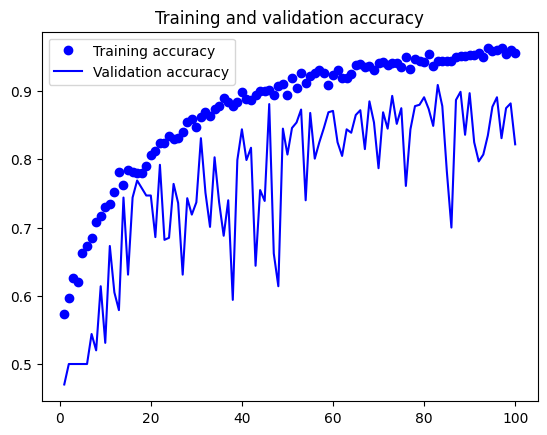

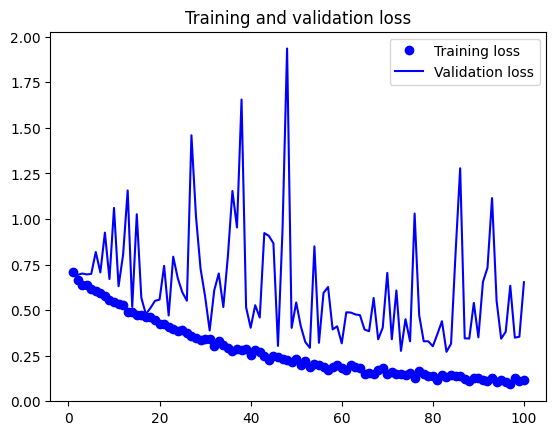

In [9]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Il modello durante la fase di training ha **raggiunto picchi di Validation Accuracy del 90%**, **rispetto ai 80/82% ottenuti sullo stesso problema ma con un modello più semplice**, composto da una serie di Conv2D e MaxPooling Layer.

In [10]:
test_model = keras.models.load_model(
  "miniXception.keras")

test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8903 - loss: 0.3766
Test accuracy: 0.890


Una gran differenza la si nota nella test accuracy. Con questo modello si ha avuto un'**accuracy dell'89%**, **mentre con il modello più semplice è stata ottenuta un'accuracy dell'81%**, **una differenza sostanziale** considerando che non sono state fatte grandi modifiche: è stato aggiunto una connessione residuale, un paio di btch normalization e i layer convulazioni classici sono stati rimpiazzati con quelli separabili.

Inoltre, avendo utilizzato dei Layer Convulazionali Separabili, **il numero di parametri allenabili di questo modelli sono stati inferiori (721.857) rispetto alla ConvNet classica (991,041).**